# Recommender System


(I) Basic Info:

In [2]:
import numpy as np
import pandas as pd 
import os
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import math
import json
import time
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
import joblib
# from sklearn.externals import joblib
import scipy.sparse 
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
import warnings; warnings.simplefilter('ignore')
%matplotlib inline


In [3]:
electronics_data = pd.read_csv("ratingsElectronics.csv", names=['userID', 'productID', 'Rating', 'timestamp'])

In [4]:
electronics_data.head()

,userID,productID,Rating,timestamp
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200


In [5]:
# rows and columns in the dataset
electronics_data.shape

(7824482, 4)

In [6]:
electronics_data.dtypes

userID        object
productID     object
Rating       float64
timestamp      int64
dtype: object

In [7]:
electronics_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824482 entries, 0 to 7824481
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userID     object 
 1   productID  object 
 2   Rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 238.8+ MB


In [8]:
# Five point summary for Rating

electronics_data.describe()['Rating'].T         # T for transpose, no apparent change if T not used

count    7.824482e+06
mean     4.012337e+00
std      1.380910e+00
min      1.000000e+00
25%      3.000000e+00
50%      5.000000e+00
75%      5.000000e+00
max      5.000000e+00
Name: Rating, dtype: float64

In [9]:
# Finding min and max ratings

print('The Minimum rating is: %d' %(electronics_data.Rating.min()))
print('The Maximum rating is: %d' %(electronics_data.Rating.max()))

The Minimum rating is: 1
The Maximum rating is: 5


(II) Handling Missing Values: 

In [10]:
# Checking missing values

print('The Number of missing values across all columns are: \n', electronics_data.isnull().sum())

# From O/P: No missing values (Good, saves the hassle)

The Number of missing values across all columns are: 
 userID       0
productID    0
Rating       0
timestamp    0
dtype: int64


(III) Ratings: 

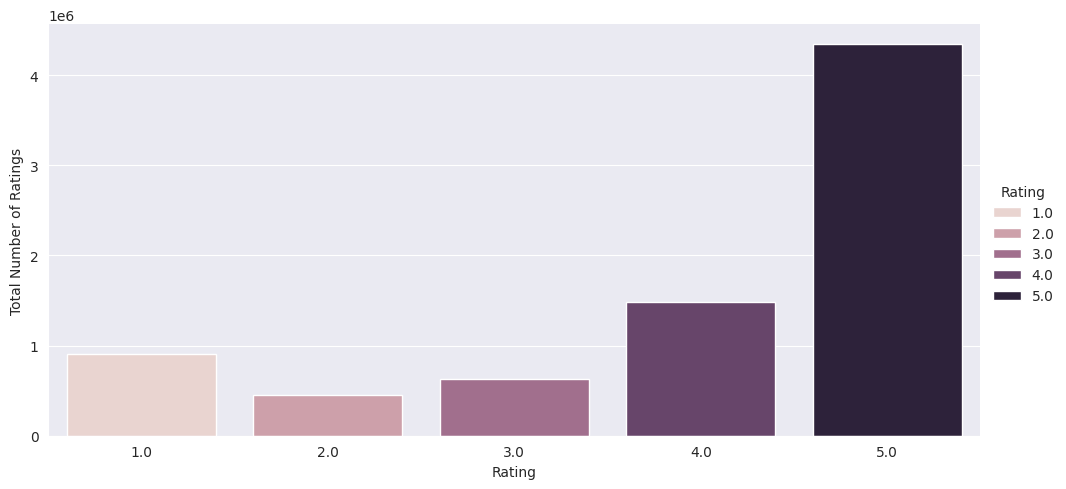

In [11]:
# Checking distribution rating

with sns.axes_style('darkgrid'):
    g = sns.catplot(x = "Rating", hue = "Rating", data = electronics_data, aspect = 2.0, kind = 'count')
    g.set_ylabels("Total Number of Ratings")

(IV) Unique Users and Products Statistics: 

In [12]:
print('Total Data: ')
print('<', '=' * 50, '>')
print('Total number of ratings: ', electronics_data.shape[0])
print('Total number of Users: ', len(np.unique(electronics_data.userID)))
print('Total number of Products: ', len(np.unique(electronics_data.productID)))

Total Data: 
< ================================================== >
Total number of ratings:  7824482
Total number of Users:  4201696
Total number of Products:  476002


(V) Since, we don't need Time-Stamp col, we will remove it

In [13]:
electronics_data.drop(['timestamp'], axis=1, inplace=True)

In [14]:
electronics_data.head()

,userID,productID,Rating
0,AKM1MP6P0OYPR,0132793040,5.0
1,A2CX7LUOHB2NDG,0321732944,5.0
2,A2NWSAGRHCP8N5,0439886341,1.0
3,A2WNBOD3WNDNKT,0439886341,3.0
4,A1GI0U4ZRJA8WN,0439886341,1.0


(VI) Analyzing the Rating

In [15]:
# Number of rating given per User

no_of_rated_products_per_user = electronics_data.groupby(by='userID')['Rating'].count().sort_values(ascending=False)

no_of_rated_products_per_user.head()

userID
A5JLAU2ARJ0BO     520
ADLVFFE4VBT8      501
A3OXHLG6DIBRW8    498
A6FIAB28IS79      431
A680RUE1FDO8B     406
Name: Rating, dtype: int64

In [16]:
no_of_rated_products_per_user.describe()

count    4.201696e+06
mean     1.862220e+00
std      2.885110e+00
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      5.200000e+02
Name: Rating, dtype: float64

In [17]:
quantiles = no_of_rated_products_per_user.quantile(np.arange(0, 1.01, 0.01), interpolation = 'higher')

<Figure size 1000x1000 with 0 Axes>

Text(0.5, 1.0, 'Quantiles and their Values')

<Axes: title={'center': 'Quantiles and their Values'}>

Text(0, 0.5, 'No. of ratigns by User')

Text(0.5, 0, 'Value at the Quantile')

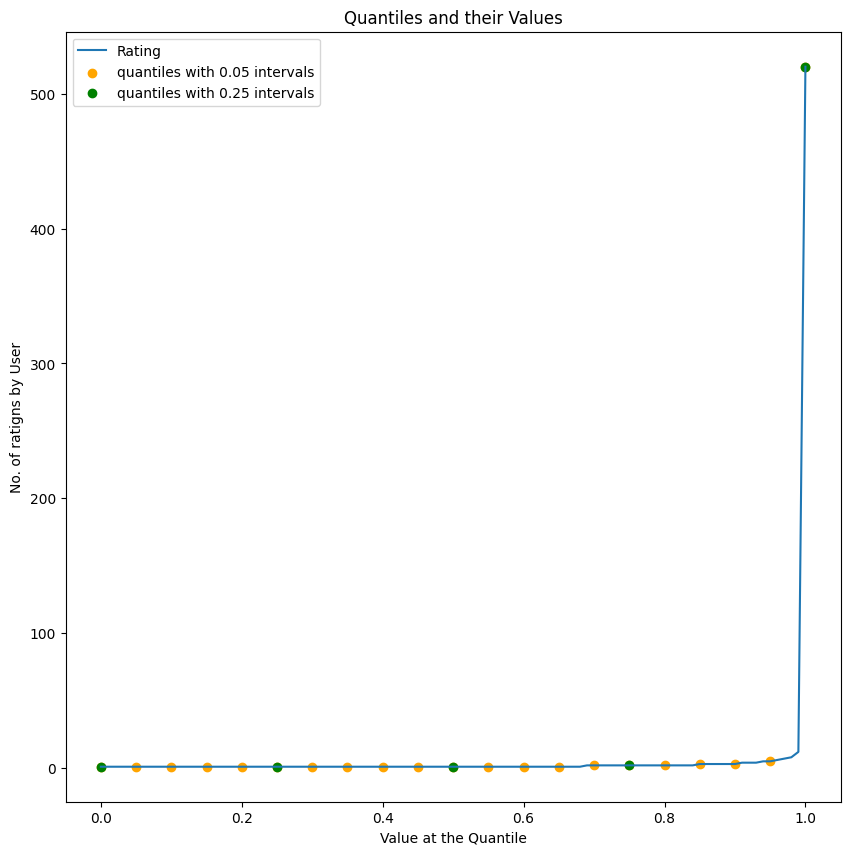

In [18]:
plt.figure(figsize=(10, 10))
plt.title("Quantiles and their Values")
quantiles.plot()

# quantiles with 0.05 difference

plt.scatter(x = quantiles.index[::5], y = quantiles.values[::5], c = 'orange', label = "quantiles with 0.05 intervals")

# quantiles with 0.25 difference

plt.scatter(x = quantiles.index[::25], y = quantiles.values[::25], c = 'green', label = "quantiles with 0.25 intervals")

plt.ylabel('No. of ratigns by User')
plt.xlabel('Value at the Quantile')
plt.legend(loc = 'best')                       # automatically selects the best location for the legend within the plot.
plt.show()

In [19]:
print('Number of rated products more than 50 per user: {}'. format(sum(no_of_rated_products_per_user >= 50)))

Number of rated products more than 50 per user: 1540


# Popularity Based Recommendation System

(I) New Dataframe

In [20]:
# Generatig new Dataframe (form previous one) which contains users who have given 50 or more ratings

new_df = electronics_data.groupby("productID").filter(lambda x:x ['Rating'].count() >= 50)

(II) Ratings per Product

Text(0.5, 1.0, '# Ratings per Product')

Text(0.5, 0, 'Product')

Text(0, 0.5, 'No. of ratings per product')

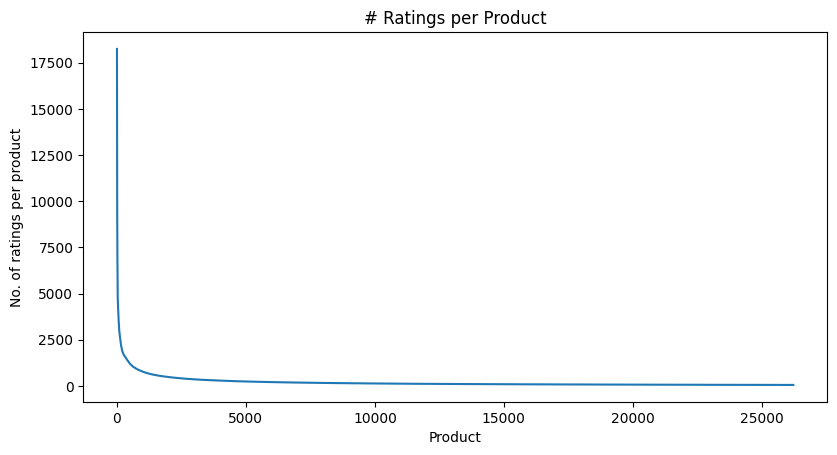

In [21]:
no_of_rated_products_per_user = new_df.groupby(by = 'productID')['Rating'].count().sort_values(ascending=False)

fig = plt.figure(figsize=plt.figaspect(.5))
ax = plt.gca()
plt.plot(no_of_rated_products_per_user.values)
plt.title('# Ratings per Product')
plt.xlabel('Product')
plt.ylabel('No. of ratings per product')
# ax.set_xticklabels([])         # Removes X label values

plt.show()

(III) Avg. rating of each product

In [22]:
new_df.groupby('productID')['Rating'].mean().head()

productID
0972683275    4.470980
1400501466    3.560000
1400501520    4.243902
1400501776    3.884892
1400532620    3.684211
Name: Rating, dtype: float64

In [23]:
new_df.groupby('productID')['Rating'].mean().sort_values(ascending=False).head()

productID
B002E6R7NG    4.980392
B004I763AW    4.966667
B003J9QQWU    4.964286
B0043ZLFXE    4.955556
B000TMFYBO    4.953125
Name: Rating, dtype: float64

(IV) Total number of Ratings for Products

In [24]:
new_df.groupby('productID')['Rating'].count().sort_values(ascending=False).head()

productID
B0074BW614    18244
B00DR0PDNE    16454
B007WTAJTO    14172
B0019EHU8G    12285
B006GWO5WK    12226
Name: Rating, dtype: int64

In [25]:
ratings_mean_count = pd.DataFrame(new_df.groupby('productID')['Rating'].mean())

In [26]:
ratings_mean_count['rating_counts'] = pd.DataFrame(new_df.groupby('productID')['Rating'].count())

In [27]:
ratings_mean_count.head()

,Rating,rating_counts
productID,,
0972683275,4.470980,1051
1400501466,3.560000,250
1400501520,4.243902,82
1400501776,3.884892,139
1400532620,3.684211,171


In [28]:
ratings_mean_count['rating_counts'].max()

18244

<Figure size 640x480 with 0 Axes>

<Axes: >

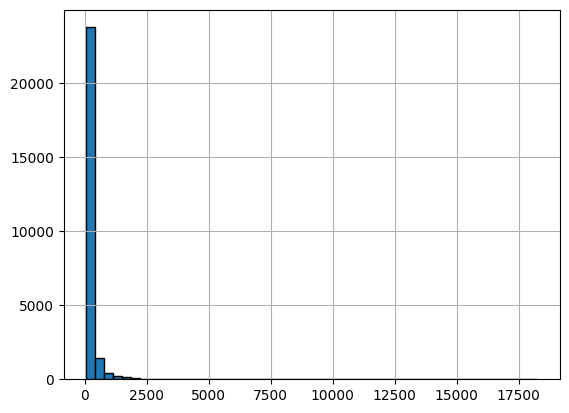

In [29]:
plt.figure()
plt.rcParams['patch.force_edgecolor'] = True
ratings_mean_count['rating_counts'].hist(bins=50)

<Figure size 640x480 with 0 Axes>

<Axes: >

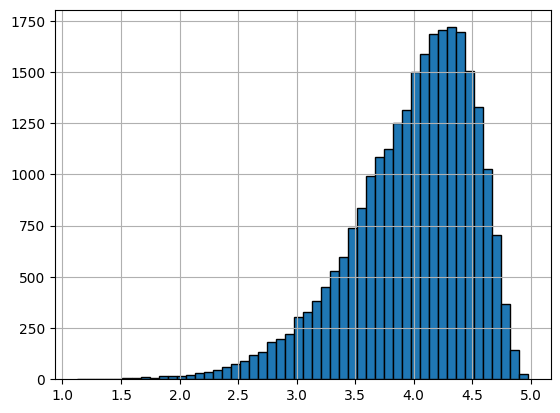

In [30]:
plt.figure()
plt.rcParams['patch.force_edgecolor'] = True
ratings_mean_count['Rating'].hist(bins=50)

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

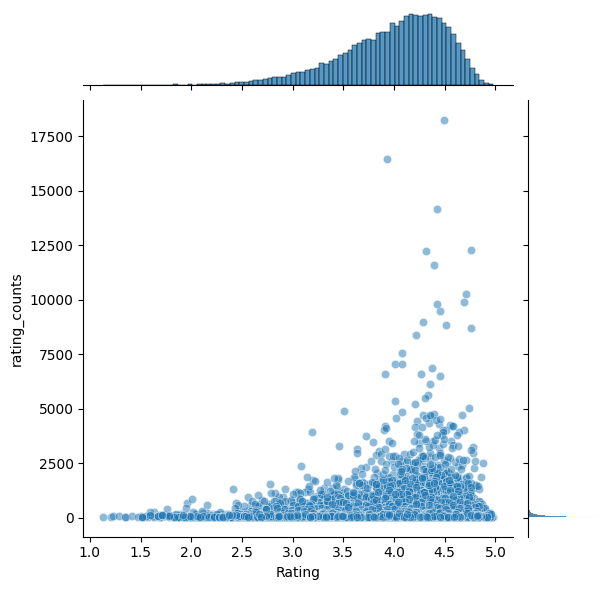

In [31]:
plt.figure(figsize=(10, 10))
plt.rcParams['patch.force_edgecolor'] = True
sns.jointplot(x = 'Rating', y = 'rating_counts', data=ratings_mean_count, alpha = 0.5)

(IV) Popular Products

<Axes: xlabel='productID'>

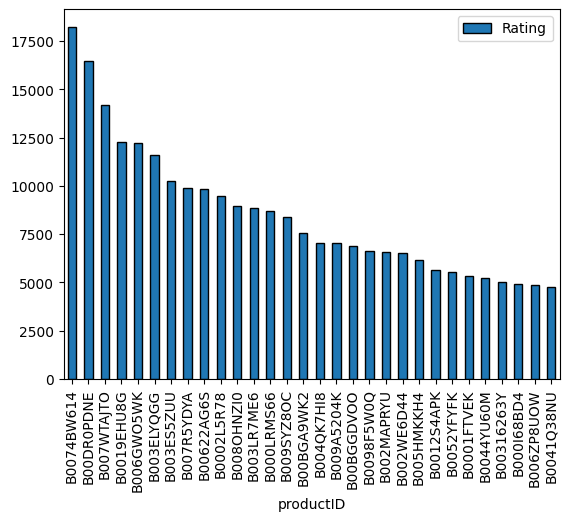

In [32]:
popular_products = pd.DataFrame(new_df.groupby('productID')['Rating'].count())
most_popular = popular_products.sort_values('Rating', ascending=False)
most_popular.head(30).plot(kind="bar")

# Collaberative Filtering (Item - Item Recommendation System)

In [33]:
from surprise import KNNWithMeans
from surprise import Dataset
from surprise import accuracy
from surprise import Reader
import os
from surprise.model_selection import train_test_split

In [34]:
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(new_df, reader)

In [35]:
trainset, testset = train_test_split(data, test_size=0.3, train_size=0.7, random_state=10)

In [36]:
# using user_based true/false for switching between user-based or item-based collaborative filtering

algo = KNNWithMeans(k = 5, sim_options={'name' : 'pearson_baseline', 'user_based' : False})
algo.fit(trainset)

Estimating biases using als...


: 